In [1]:
from concrete_autoencoder import ConcreteAutoencoderFeatureSelector

In [2]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

In [6]:
train_data, test_data = generate_synthetic_data_with_noise(N, z_size, D)

In [7]:
class CEConcreteAutoencoderFeatureSelector(ConcreteAutoencoderFeatureSelector):
    def __init__(self, K, output_function, num_epochs = 300, batch_size = None, learning_rate = 0.001, start_temp = 10.0, min_temp = 0.1, tryout_limit = 5):
            super(CEConcreteAutoencoderFeatureSelector, self).__init__(K, output_function, num_epochs, batch_size, learning_rate, start_temp, min_temp, tryout_limit)
    
    
    def fit(self, X, Y = None, val_X = None, val_Y = None):
        if Y is None:
            Y = X
        assert len(X) == len(Y)
        validation_data = None
        if val_X is not None and val_Y is not None:
            assert len(val_X) == len(val_Y)
            validation_data = (val_X, val_Y)
        
        if self.batch_size is None:
            self.batch_size = max(len(X) // 256, 16)
        
        num_epochs = self.num_epochs
        steps_per_epoch = (len(X) + self.batch_size - 1) // self.batch_size
        
        for i in range(self.tryout_limit):
            
            K.set_learning_phase(1)
            
            inputs = Input(shape = X.shape[1:])

            alpha = math.exp(math.log(self.min_temp / self.start_temp) / (num_epochs * steps_per_epoch))
            
            self.concrete_select = ConcreteSelect(self.K, self.start_temp, self.min_temp, alpha, name = 'concrete_select')

            selected_features = self.concrete_select(inputs)

            outputs = self.output_function(selected_features)

            self.model = Model(inputs, outputs)

            self.model.compile(Adam(self.learning_rate), loss = 'binary_crossentropy')
            
            print(self.model.summary())
            
            stopper_callback = StopperCallback()
            
            hist = self.model.fit(X, Y, self.batch_size, num_epochs, verbose = 1, callbacks = [stopper_callback], validation_data = validation_data)#, validation_freq = 10)
            
            if K.get_value(K.mean(K.max(K.softmax(self.concrete_select.logits, axis = -1)))) >= stopper_callback.mean_max_target:
                break
            
            num_epochs *= 2
        
        self.probabilities = K.get_value(K.softmax(self.model.get_layer('concrete_select').logits))
        self.indices = K.get_value(K.argmax(self.model.get_layer('concrete_select').logits))
            
        return self

convert torch tensors to tf tensors

In [8]:
def tf_to_to(df):
    df = df.cpu().numpy()
    return tf.convert_to_tensor(df)

In [9]:
#train_data = tf_to_to(train_data)
#test_data = tf_to_to(test_data)

In [10]:
def decoder(x):
    x = Dense(D)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(2*D)(x)
    x = tf.keras.activations.sigmoid(x)
    return x

#selector = CEConcreteAutoencoderFeatureSelector(K = 3*z_size, output_function = decoder, num_epochs = 800)

#selector.fit(train_data, train_data, test_data, test_data)

In [11]:
#ind = selector.get_support(indices=True)

In [12]:
#sum(ind < 30)

In [13]:
#sum(ind >= 30)

In [14]:
#K.argmax(selector.model.get_layer('concrete_select').logits)

In [15]:
#selector.model.get_layer('concrete_select').logits.shape

End of their implementation and try mine

In [16]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999
k = 30

In [17]:
global_t = 4

In [18]:
vae_gumbel_truncated = ConcreteVAE_NMSL(2*D, hidden_layer_size = 100, z_size = 20, k = k, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [19]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

Train Epoch: 1 [0/8000 (0%)]	Loss: 42.032932
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.481266
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.892509
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.322788
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.881104
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.126789
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.581730
====> Epoch: 1 Average loss: 40.2507
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.100838
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.378792
Train Epoch: 2 [2560/8000 (32%)]	Loss: 36.700859
Train Epoch: 2 [3840/8000 (48%)]	Loss: 35.817719
Train Epoch: 2 [5120/8000 (64%)]	Loss: 34.888977
Train Epoch: 2 [6400/8000 (80%)]	Loss: 34.941116
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.029480
====> Epoch: 2 Average loss: 35.9702
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.463028
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.219902
Train Epoch: 3 [2560/8000 (32%)]	Loss: 33.641449
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.766911
Train Epoch: 3 [5120/8000 (64%)]	Loss: 34.073734
Train E

Train Epoch: 22 [7680/8000 (96%)]	Loss: 32.465481
====> Epoch: 22 Average loss: 32.3445
Train Epoch: 23 [0/8000 (0%)]	Loss: 32.455887
Train Epoch: 23 [1280/8000 (16%)]	Loss: 32.849007
Train Epoch: 23 [2560/8000 (32%)]	Loss: 32.257576
Train Epoch: 23 [3840/8000 (48%)]	Loss: 31.954285
Train Epoch: 23 [5120/8000 (64%)]	Loss: 32.399227
Train Epoch: 23 [6400/8000 (80%)]	Loss: 32.398972
Train Epoch: 23 [7680/8000 (96%)]	Loss: 32.269672
====> Epoch: 23 Average loss: 32.3027
Train Epoch: 24 [0/8000 (0%)]	Loss: 32.559624
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.852074
Train Epoch: 24 [2560/8000 (32%)]	Loss: 32.562115
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.849979
Train Epoch: 24 [5120/8000 (64%)]	Loss: 32.498146
Train Epoch: 24 [6400/8000 (80%)]	Loss: 31.950886
Train Epoch: 24 [7680/8000 (96%)]	Loss: 32.070175
====> Epoch: 24 Average loss: 32.2809
Train Epoch: 25 [0/8000 (0%)]	Loss: 32.000820
Train Epoch: 25 [1280/8000 (16%)]	Loss: 32.344025
Train Epoch: 25 [2560/8000 (32%)]	Loss: 32.19902

Train Epoch: 44 [1280/8000 (16%)]	Loss: 31.910355
Train Epoch: 44 [2560/8000 (32%)]	Loss: 32.103706
Train Epoch: 44 [3840/8000 (48%)]	Loss: 32.272354
Train Epoch: 44 [5120/8000 (64%)]	Loss: 32.057068
Train Epoch: 44 [6400/8000 (80%)]	Loss: 32.500179
Train Epoch: 44 [7680/8000 (96%)]	Loss: 32.287643
====> Epoch: 44 Average loss: 32.1659
Train Epoch: 45 [0/8000 (0%)]	Loss: 32.008606
Train Epoch: 45 [1280/8000 (16%)]	Loss: 31.603792
Train Epoch: 45 [2560/8000 (32%)]	Loss: 32.414471
Train Epoch: 45 [3840/8000 (48%)]	Loss: 31.795397
Train Epoch: 45 [5120/8000 (64%)]	Loss: 31.523989
Train Epoch: 45 [6400/8000 (80%)]	Loss: 32.018806
Train Epoch: 45 [7680/8000 (96%)]	Loss: 32.460754
====> Epoch: 45 Average loss: 32.1588
Train Epoch: 46 [0/8000 (0%)]	Loss: 31.539167
Train Epoch: 46 [1280/8000 (16%)]	Loss: 32.233360
Train Epoch: 46 [2560/8000 (32%)]	Loss: 32.533901
Train Epoch: 46 [3840/8000 (48%)]	Loss: 32.573635
Train Epoch: 46 [5120/8000 (64%)]	Loss: 31.999752
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 32.140049
Train Epoch: 65 [6400/8000 (80%)]	Loss: 32.442230
Train Epoch: 65 [7680/8000 (96%)]	Loss: 32.194489
====> Epoch: 65 Average loss: 32.0535
Train Epoch: 66 [0/8000 (0%)]	Loss: 32.197025
Train Epoch: 66 [1280/8000 (16%)]	Loss: 32.036976
Train Epoch: 66 [2560/8000 (32%)]	Loss: 32.012436
Train Epoch: 66 [3840/8000 (48%)]	Loss: 32.121651
Train Epoch: 66 [5120/8000 (64%)]	Loss: 32.351135
Train Epoch: 66 [6400/8000 (80%)]	Loss: 32.204517
Train Epoch: 66 [7680/8000 (96%)]	Loss: 32.148197
====> Epoch: 66 Average loss: 32.0373
Train Epoch: 67 [0/8000 (0%)]	Loss: 32.176163
Train Epoch: 67 [1280/8000 (16%)]	Loss: 32.038605
Train Epoch: 67 [2560/8000 (32%)]	Loss: 32.170292
Train Epoch: 67 [3840/8000 (48%)]	Loss: 32.157471
Train Epoch: 67 [5120/8000 (64%)]	Loss: 31.974728
Train Epoch: 67 [6400/8000 (80%)]	Loss: 32.226788
Train Epoch: 67 [7680/8000 (96%)]	Loss: 32.080761
====> Epoch: 67 Average loss: 32.0308
Train Epoch: 68 [0/8000 (0%)]	Loss: 31.96645

Train Epoch: 87 [2560/8000 (32%)]	Loss: 32.041031
Train Epoch: 87 [3840/8000 (48%)]	Loss: 31.792368
Train Epoch: 87 [5120/8000 (64%)]	Loss: 31.805237
Train Epoch: 87 [6400/8000 (80%)]	Loss: 31.676540
Train Epoch: 87 [7680/8000 (96%)]	Loss: 32.088604
====> Epoch: 87 Average loss: 31.8583
Train Epoch: 88 [0/8000 (0%)]	Loss: 31.722336
Train Epoch: 88 [1280/8000 (16%)]	Loss: 31.534782
Train Epoch: 88 [2560/8000 (32%)]	Loss: 31.834026
Train Epoch: 88 [3840/8000 (48%)]	Loss: 31.555861
Train Epoch: 88 [5120/8000 (64%)]	Loss: 31.757267
Train Epoch: 88 [6400/8000 (80%)]	Loss: 31.640520
Train Epoch: 88 [7680/8000 (96%)]	Loss: 31.918644
====> Epoch: 88 Average loss: 31.8485
Train Epoch: 89 [0/8000 (0%)]	Loss: 31.958628
Train Epoch: 89 [1280/8000 (16%)]	Loss: 31.415400
Train Epoch: 89 [2560/8000 (32%)]	Loss: 31.726791
Train Epoch: 89 [3840/8000 (48%)]	Loss: 31.991547
Train Epoch: 89 [5120/8000 (64%)]	Loss: 31.707882
Train Epoch: 89 [6400/8000 (80%)]	Loss: 31.485945
Train Epoch: 89 [7680/8000 (96%)

Train Epoch: 108 [5120/8000 (64%)]	Loss: 32.071941
Train Epoch: 108 [6400/8000 (80%)]	Loss: 32.080284
Train Epoch: 108 [7680/8000 (96%)]	Loss: 31.613768
====> Epoch: 108 Average loss: 31.7548
Train Epoch: 109 [0/8000 (0%)]	Loss: 31.277952
Train Epoch: 109 [1280/8000 (16%)]	Loss: 31.824381
Train Epoch: 109 [2560/8000 (32%)]	Loss: 31.975376
Train Epoch: 109 [3840/8000 (48%)]	Loss: 31.906864
Train Epoch: 109 [5120/8000 (64%)]	Loss: 31.878998
Train Epoch: 109 [6400/8000 (80%)]	Loss: 31.699421
Train Epoch: 109 [7680/8000 (96%)]	Loss: 31.697662
====> Epoch: 109 Average loss: 31.7367
Train Epoch: 110 [0/8000 (0%)]	Loss: 31.904379
Train Epoch: 110 [1280/8000 (16%)]	Loss: 31.744907
Train Epoch: 110 [2560/8000 (32%)]	Loss: 31.672249
Train Epoch: 110 [3840/8000 (48%)]	Loss: 32.145287
Train Epoch: 110 [5120/8000 (64%)]	Loss: 31.597452
Train Epoch: 110 [6400/8000 (80%)]	Loss: 32.037643
Train Epoch: 110 [7680/8000 (96%)]	Loss: 31.729769
====> Epoch: 110 Average loss: 31.7400
Train Epoch: 111 [0/8000

Train Epoch: 129 [5120/8000 (64%)]	Loss: 31.748528
Train Epoch: 129 [6400/8000 (80%)]	Loss: 31.919481
Train Epoch: 129 [7680/8000 (96%)]	Loss: 31.782261
====> Epoch: 129 Average loss: 31.6469
Train Epoch: 130 [0/8000 (0%)]	Loss: 31.642879
Train Epoch: 130 [1280/8000 (16%)]	Loss: 31.676699
Train Epoch: 130 [2560/8000 (32%)]	Loss: 31.416723
Train Epoch: 130 [3840/8000 (48%)]	Loss: 31.305431
Train Epoch: 130 [5120/8000 (64%)]	Loss: 31.654350
Train Epoch: 130 [6400/8000 (80%)]	Loss: 31.983557
Train Epoch: 130 [7680/8000 (96%)]	Loss: 31.638603
====> Epoch: 130 Average loss: 31.6467
Train Epoch: 131 [0/8000 (0%)]	Loss: 32.130138
Train Epoch: 131 [1280/8000 (16%)]	Loss: 31.692955
Train Epoch: 131 [2560/8000 (32%)]	Loss: 31.323584
Train Epoch: 131 [3840/8000 (48%)]	Loss: 31.490150
Train Epoch: 131 [5120/8000 (64%)]	Loss: 31.848717
Train Epoch: 131 [6400/8000 (80%)]	Loss: 31.574245
Train Epoch: 131 [7680/8000 (96%)]	Loss: 31.234657
====> Epoch: 131 Average loss: 31.6304
Train Epoch: 132 [0/8000

Train Epoch: 150 [5120/8000 (64%)]	Loss: 31.304144
Train Epoch: 150 [6400/8000 (80%)]	Loss: 31.090345
Train Epoch: 150 [7680/8000 (96%)]	Loss: 31.363865
====> Epoch: 150 Average loss: 31.5069
Train Epoch: 151 [0/8000 (0%)]	Loss: 31.670937
Train Epoch: 151 [1280/8000 (16%)]	Loss: 31.450901
Train Epoch: 151 [2560/8000 (32%)]	Loss: 31.677193
Train Epoch: 151 [3840/8000 (48%)]	Loss: 31.531698
Train Epoch: 151 [5120/8000 (64%)]	Loss: 31.373638
Train Epoch: 151 [6400/8000 (80%)]	Loss: 31.721617
Train Epoch: 151 [7680/8000 (96%)]	Loss: 31.534935
====> Epoch: 151 Average loss: 31.4996
Train Epoch: 152 [0/8000 (0%)]	Loss: 31.788185
Train Epoch: 152 [1280/8000 (16%)]	Loss: 31.111494
Train Epoch: 152 [2560/8000 (32%)]	Loss: 31.567844
Train Epoch: 152 [3840/8000 (48%)]	Loss: 31.210598
Train Epoch: 152 [5120/8000 (64%)]	Loss: 31.362818
Train Epoch: 152 [6400/8000 (80%)]	Loss: 31.299082
Train Epoch: 152 [7680/8000 (96%)]	Loss: 31.616991
====> Epoch: 152 Average loss: 31.4966
Train Epoch: 153 [0/8000

Train Epoch: 171 [5120/8000 (64%)]	Loss: 30.760368
Train Epoch: 171 [6400/8000 (80%)]	Loss: 30.963633
Train Epoch: 171 [7680/8000 (96%)]	Loss: 31.567175
====> Epoch: 171 Average loss: 31.3048
Train Epoch: 172 [0/8000 (0%)]	Loss: 31.403521
Train Epoch: 172 [1280/8000 (16%)]	Loss: 31.064608
Train Epoch: 172 [2560/8000 (32%)]	Loss: 31.424713
Train Epoch: 172 [3840/8000 (48%)]	Loss: 31.278843
Train Epoch: 172 [5120/8000 (64%)]	Loss: 31.259710
Train Epoch: 172 [6400/8000 (80%)]	Loss: 31.758850
Train Epoch: 172 [7680/8000 (96%)]	Loss: 30.917507
====> Epoch: 172 Average loss: 31.3093
Train Epoch: 173 [0/8000 (0%)]	Loss: 31.376358
Train Epoch: 173 [1280/8000 (16%)]	Loss: 31.158497
Train Epoch: 173 [2560/8000 (32%)]	Loss: 31.535616
Train Epoch: 173 [3840/8000 (48%)]	Loss: 31.293919
Train Epoch: 173 [5120/8000 (64%)]	Loss: 31.471554
Train Epoch: 173 [6400/8000 (80%)]	Loss: 31.042522
Train Epoch: 173 [7680/8000 (96%)]	Loss: 31.279659
====> Epoch: 173 Average loss: 31.2946
Train Epoch: 174 [0/8000

Train Epoch: 192 [5120/8000 (64%)]	Loss: 31.298416
Train Epoch: 192 [6400/8000 (80%)]	Loss: 31.351254
Train Epoch: 192 [7680/8000 (96%)]	Loss: 31.366032
====> Epoch: 192 Average loss: 31.2007
Train Epoch: 193 [0/8000 (0%)]	Loss: 31.007874
Train Epoch: 193 [1280/8000 (16%)]	Loss: 31.204014
Train Epoch: 193 [2560/8000 (32%)]	Loss: 31.237597
Train Epoch: 193 [3840/8000 (48%)]	Loss: 31.244026
Train Epoch: 193 [5120/8000 (64%)]	Loss: 31.525475
Train Epoch: 193 [6400/8000 (80%)]	Loss: 31.297522
Train Epoch: 193 [7680/8000 (96%)]	Loss: 31.212889
====> Epoch: 193 Average loss: 31.1890
Train Epoch: 194 [0/8000 (0%)]	Loss: 31.097084
Train Epoch: 194 [1280/8000 (16%)]	Loss: 31.466923
Train Epoch: 194 [2560/8000 (32%)]	Loss: 31.656416
Train Epoch: 194 [3840/8000 (48%)]	Loss: 31.080616
Train Epoch: 194 [5120/8000 (64%)]	Loss: 31.112045
Train Epoch: 194 [6400/8000 (80%)]	Loss: 31.578106
Train Epoch: 194 [7680/8000 (96%)]	Loss: 31.531782
====> Epoch: 194 Average loss: 31.1856
Train Epoch: 195 [0/8000

Train Epoch: 213 [5120/8000 (64%)]	Loss: 31.081194
Train Epoch: 213 [6400/8000 (80%)]	Loss: 31.089802
Train Epoch: 213 [7680/8000 (96%)]	Loss: 31.185005
====> Epoch: 213 Average loss: 31.0821
Train Epoch: 214 [0/8000 (0%)]	Loss: 31.059238
Train Epoch: 214 [1280/8000 (16%)]	Loss: 31.351978
Train Epoch: 214 [2560/8000 (32%)]	Loss: 30.939821
Train Epoch: 214 [3840/8000 (48%)]	Loss: 31.067541
Train Epoch: 214 [5120/8000 (64%)]	Loss: 31.167591
Train Epoch: 214 [6400/8000 (80%)]	Loss: 30.734091
Train Epoch: 214 [7680/8000 (96%)]	Loss: 31.452854
====> Epoch: 214 Average loss: 31.0897
Train Epoch: 215 [0/8000 (0%)]	Loss: 30.619766
Train Epoch: 215 [1280/8000 (16%)]	Loss: 31.205385
Train Epoch: 215 [2560/8000 (32%)]	Loss: 31.345055
Train Epoch: 215 [3840/8000 (48%)]	Loss: 31.033979
Train Epoch: 215 [5120/8000 (64%)]	Loss: 31.053125
Train Epoch: 215 [6400/8000 (80%)]	Loss: 31.019165
Train Epoch: 215 [7680/8000 (96%)]	Loss: 30.864769
====> Epoch: 215 Average loss: 31.0751
Train Epoch: 216 [0/8000

Train Epoch: 234 [5120/8000 (64%)]	Loss: 30.603462
Train Epoch: 234 [6400/8000 (80%)]	Loss: 31.010908
Train Epoch: 234 [7680/8000 (96%)]	Loss: 30.745380
====> Epoch: 234 Average loss: 31.0122
Train Epoch: 235 [0/8000 (0%)]	Loss: 30.847834
Train Epoch: 235 [1280/8000 (16%)]	Loss: 31.132999
Train Epoch: 235 [2560/8000 (32%)]	Loss: 30.843695
Train Epoch: 235 [3840/8000 (48%)]	Loss: 31.038326
Train Epoch: 235 [5120/8000 (64%)]	Loss: 31.549709
Train Epoch: 235 [6400/8000 (80%)]	Loss: 30.963783
Train Epoch: 235 [7680/8000 (96%)]	Loss: 31.096897
====> Epoch: 235 Average loss: 31.0058
Train Epoch: 236 [0/8000 (0%)]	Loss: 30.672400
Train Epoch: 236 [1280/8000 (16%)]	Loss: 31.081715
Train Epoch: 236 [2560/8000 (32%)]	Loss: 30.842352
Train Epoch: 236 [3840/8000 (48%)]	Loss: 31.067505
Train Epoch: 236 [5120/8000 (64%)]	Loss: 30.779955
Train Epoch: 236 [6400/8000 (80%)]	Loss: 30.929304
Train Epoch: 236 [7680/8000 (96%)]	Loss: 31.022587
====> Epoch: 236 Average loss: 30.9959
Train Epoch: 237 [0/8000

Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.672174
Train Epoch: 255 [7680/8000 (96%)]	Loss: 30.734280
====> Epoch: 255 Average loss: 30.9547
Train Epoch: 256 [0/8000 (0%)]	Loss: 30.441469
Train Epoch: 256 [1280/8000 (16%)]	Loss: 30.769245
Train Epoch: 256 [2560/8000 (32%)]	Loss: 30.933390
Train Epoch: 256 [3840/8000 (48%)]	Loss: 31.182625
Train Epoch: 256 [5120/8000 (64%)]	Loss: 31.335808
Train Epoch: 256 [6400/8000 (80%)]	Loss: 31.111488
Train Epoch: 256 [7680/8000 (96%)]	Loss: 31.208673
====> Epoch: 256 Average loss: 30.9347
Train Epoch: 257 [0/8000 (0%)]	Loss: 31.462442
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.618263
Train Epoch: 257 [2560/8000 (32%)]	Loss: 31.125227
Train Epoch: 257 [3840/8000 (48%)]	Loss: 30.560061
Train Epoch: 257 [5120/8000 (64%)]	Loss: 30.696745
Train Epoch: 257 [6400/8000 (80%)]	Loss: 30.778044
Train Epoch: 257 [7680/8000 (96%)]	Loss: 30.617378
====> Epoch: 257 Average loss: 30.9292
Train Epoch: 258 [0/8000 (0%)]	Loss: 30.981016
Train Epoch: 258 [1280/8000 

Train Epoch: 276 [6400/8000 (80%)]	Loss: 30.682600
Train Epoch: 276 [7680/8000 (96%)]	Loss: 30.705351
====> Epoch: 276 Average loss: 30.8156
Train Epoch: 277 [0/8000 (0%)]	Loss: 30.881819
Train Epoch: 277 [1280/8000 (16%)]	Loss: 30.934265
Train Epoch: 277 [2560/8000 (32%)]	Loss: 30.712492
Train Epoch: 277 [3840/8000 (48%)]	Loss: 30.783918
Train Epoch: 277 [5120/8000 (64%)]	Loss: 30.860605
Train Epoch: 277 [6400/8000 (80%)]	Loss: 31.047543
Train Epoch: 277 [7680/8000 (96%)]	Loss: 31.011082
====> Epoch: 277 Average loss: 30.8197
Train Epoch: 278 [0/8000 (0%)]	Loss: 30.790499
Train Epoch: 278 [1280/8000 (16%)]	Loss: 30.655514
Train Epoch: 278 [2560/8000 (32%)]	Loss: 30.847597
Train Epoch: 278 [3840/8000 (48%)]	Loss: 31.031275
Train Epoch: 278 [5120/8000 (64%)]	Loss: 30.769598
Train Epoch: 278 [6400/8000 (80%)]	Loss: 30.788902
Train Epoch: 278 [7680/8000 (96%)]	Loss: 30.746534
====> Epoch: 278 Average loss: 30.8108
Train Epoch: 279 [0/8000 (0%)]	Loss: 30.651552
Train Epoch: 279 [1280/8000 

Train Epoch: 297 [6400/8000 (80%)]	Loss: 30.505358
Train Epoch: 297 [7680/8000 (96%)]	Loss: 31.228312
====> Epoch: 297 Average loss: 30.7521
Train Epoch: 298 [0/8000 (0%)]	Loss: 31.015860
Train Epoch: 298 [1280/8000 (16%)]	Loss: 30.594982
Train Epoch: 298 [2560/8000 (32%)]	Loss: 30.746418
Train Epoch: 298 [3840/8000 (48%)]	Loss: 30.863298
Train Epoch: 298 [5120/8000 (64%)]	Loss: 30.738235
Train Epoch: 298 [6400/8000 (80%)]	Loss: 30.780544
Train Epoch: 298 [7680/8000 (96%)]	Loss: 30.881889
====> Epoch: 298 Average loss: 30.7417
Train Epoch: 299 [0/8000 (0%)]	Loss: 30.627016
Train Epoch: 299 [1280/8000 (16%)]	Loss: 30.923758
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.699871
Train Epoch: 299 [3840/8000 (48%)]	Loss: 30.653406
Train Epoch: 299 [5120/8000 (64%)]	Loss: 30.520180
Train Epoch: 299 [6400/8000 (80%)]	Loss: 31.073324
Train Epoch: 299 [7680/8000 (96%)]	Loss: 31.158501
====> Epoch: 299 Average loss: 30.7189
Train Epoch: 300 [0/8000 (0%)]	Loss: 30.780785
Train Epoch: 300 [1280/8000 

Train Epoch: 318 [6400/8000 (80%)]	Loss: 30.661957
Train Epoch: 318 [7680/8000 (96%)]	Loss: 30.769968
====> Epoch: 318 Average loss: 30.6973
Train Epoch: 319 [0/8000 (0%)]	Loss: 30.744558
Train Epoch: 319 [1280/8000 (16%)]	Loss: 30.671036
Train Epoch: 319 [2560/8000 (32%)]	Loss: 30.445852
Train Epoch: 319 [3840/8000 (48%)]	Loss: 31.051836
Train Epoch: 319 [5120/8000 (64%)]	Loss: 30.377863
Train Epoch: 319 [6400/8000 (80%)]	Loss: 30.797323
Train Epoch: 319 [7680/8000 (96%)]	Loss: 30.960522
====> Epoch: 319 Average loss: 30.6992
Train Epoch: 320 [0/8000 (0%)]	Loss: 30.489691
Train Epoch: 320 [1280/8000 (16%)]	Loss: 30.521738
Train Epoch: 320 [2560/8000 (32%)]	Loss: 30.692732
Train Epoch: 320 [3840/8000 (48%)]	Loss: 30.852526
Train Epoch: 320 [5120/8000 (64%)]	Loss: 30.690378
Train Epoch: 320 [6400/8000 (80%)]	Loss: 30.598639
Train Epoch: 320 [7680/8000 (96%)]	Loss: 31.161900
====> Epoch: 320 Average loss: 30.7009
Train Epoch: 321 [0/8000 (0%)]	Loss: 30.753204
Train Epoch: 321 [1280/8000 

Train Epoch: 339 [6400/8000 (80%)]	Loss: 30.555799
Train Epoch: 339 [7680/8000 (96%)]	Loss: 30.372259
====> Epoch: 339 Average loss: 30.6599
Train Epoch: 340 [0/8000 (0%)]	Loss: 30.530678
Train Epoch: 340 [1280/8000 (16%)]	Loss: 30.901318
Train Epoch: 340 [2560/8000 (32%)]	Loss: 30.269402
Train Epoch: 340 [3840/8000 (48%)]	Loss: 30.337517
Train Epoch: 340 [5120/8000 (64%)]	Loss: 30.422840
Train Epoch: 340 [6400/8000 (80%)]	Loss: 30.808245
Train Epoch: 340 [7680/8000 (96%)]	Loss: 30.772604
====> Epoch: 340 Average loss: 30.6501
Train Epoch: 341 [0/8000 (0%)]	Loss: 30.767883
Train Epoch: 341 [1280/8000 (16%)]	Loss: 30.650406
Train Epoch: 341 [2560/8000 (32%)]	Loss: 30.703960
Train Epoch: 341 [3840/8000 (48%)]	Loss: 30.633730
Train Epoch: 341 [5120/8000 (64%)]	Loss: 30.420254
Train Epoch: 341 [6400/8000 (80%)]	Loss: 30.854134
Train Epoch: 341 [7680/8000 (96%)]	Loss: 30.565737
====> Epoch: 341 Average loss: 30.6502
Train Epoch: 342 [0/8000 (0%)]	Loss: 30.691551
Train Epoch: 342 [1280/8000 

Train Epoch: 360 [6400/8000 (80%)]	Loss: 30.338194
Train Epoch: 360 [7680/8000 (96%)]	Loss: 30.541367
====> Epoch: 360 Average loss: 30.6425
Train Epoch: 361 [0/8000 (0%)]	Loss: 30.605312
Train Epoch: 361 [1280/8000 (16%)]	Loss: 30.959713
Train Epoch: 361 [2560/8000 (32%)]	Loss: 30.193827
Train Epoch: 361 [3840/8000 (48%)]	Loss: 30.462301
Train Epoch: 361 [5120/8000 (64%)]	Loss: 30.501520
Train Epoch: 361 [6400/8000 (80%)]	Loss: 30.298044
Train Epoch: 361 [7680/8000 (96%)]	Loss: 31.573853
====> Epoch: 361 Average loss: 30.6248
Train Epoch: 362 [0/8000 (0%)]	Loss: 30.840509
Train Epoch: 362 [1280/8000 (16%)]	Loss: 30.770763
Train Epoch: 362 [2560/8000 (32%)]	Loss: 30.326271
Train Epoch: 362 [3840/8000 (48%)]	Loss: 30.236197
Train Epoch: 362 [5120/8000 (64%)]	Loss: 30.843321
Train Epoch: 362 [6400/8000 (80%)]	Loss: 31.136030
Train Epoch: 362 [7680/8000 (96%)]	Loss: 31.007515
====> Epoch: 362 Average loss: 30.6148
Train Epoch: 363 [0/8000 (0%)]	Loss: 30.735773
Train Epoch: 363 [1280/8000 

Train Epoch: 381 [6400/8000 (80%)]	Loss: 30.613266
Train Epoch: 381 [7680/8000 (96%)]	Loss: 30.587961
====> Epoch: 381 Average loss: 30.5988
Train Epoch: 382 [0/8000 (0%)]	Loss: 30.241480
Train Epoch: 382 [1280/8000 (16%)]	Loss: 30.796221
Train Epoch: 382 [2560/8000 (32%)]	Loss: 30.499821
Train Epoch: 382 [3840/8000 (48%)]	Loss: 30.376545
Train Epoch: 382 [5120/8000 (64%)]	Loss: 30.954206
Train Epoch: 382 [6400/8000 (80%)]	Loss: 30.423279
Train Epoch: 382 [7680/8000 (96%)]	Loss: 30.976562
====> Epoch: 382 Average loss: 30.6077
Train Epoch: 383 [0/8000 (0%)]	Loss: 30.307331
Train Epoch: 383 [1280/8000 (16%)]	Loss: 30.697111
Train Epoch: 383 [2560/8000 (32%)]	Loss: 30.557516
Train Epoch: 383 [3840/8000 (48%)]	Loss: 30.577129
Train Epoch: 383 [5120/8000 (64%)]	Loss: 30.887417
Train Epoch: 383 [6400/8000 (80%)]	Loss: 30.318979
Train Epoch: 383 [7680/8000 (96%)]	Loss: 30.378222
====> Epoch: 383 Average loss: 30.6114
Train Epoch: 384 [0/8000 (0%)]	Loss: 30.521498
Train Epoch: 384 [1280/8000 

Train Epoch: 402 [7680/8000 (96%)]	Loss: 30.831610
====> Epoch: 402 Average loss: 30.5808
Train Epoch: 403 [0/8000 (0%)]	Loss: 30.624401
Train Epoch: 403 [1280/8000 (16%)]	Loss: 30.544422
Train Epoch: 403 [2560/8000 (32%)]	Loss: 30.445524
Train Epoch: 403 [3840/8000 (48%)]	Loss: 30.335373
Train Epoch: 403 [5120/8000 (64%)]	Loss: 30.702297
Train Epoch: 403 [6400/8000 (80%)]	Loss: 30.648479
Train Epoch: 403 [7680/8000 (96%)]	Loss: 31.003319
====> Epoch: 403 Average loss: 30.5644
Train Epoch: 404 [0/8000 (0%)]	Loss: 30.443150
Train Epoch: 404 [1280/8000 (16%)]	Loss: 30.351091
Train Epoch: 404 [2560/8000 (32%)]	Loss: 30.790279
Train Epoch: 404 [3840/8000 (48%)]	Loss: 30.596947
Train Epoch: 404 [5120/8000 (64%)]	Loss: 30.402456
Train Epoch: 404 [6400/8000 (80%)]	Loss: 30.525547
Train Epoch: 404 [7680/8000 (96%)]	Loss: 31.005157
====> Epoch: 404 Average loss: 30.5920
Train Epoch: 405 [0/8000 (0%)]	Loss: 30.570068
Train Epoch: 405 [1280/8000 (16%)]	Loss: 30.924179
Train Epoch: 405 [2560/8000 

Train Epoch: 423 [7680/8000 (96%)]	Loss: 30.575031
====> Epoch: 423 Average loss: 30.5255
Train Epoch: 424 [0/8000 (0%)]	Loss: 30.992437
Train Epoch: 424 [1280/8000 (16%)]	Loss: 30.403454
Train Epoch: 424 [2560/8000 (32%)]	Loss: 30.383553
Train Epoch: 424 [3840/8000 (48%)]	Loss: 30.508514
Train Epoch: 424 [5120/8000 (64%)]	Loss: 30.550611
Train Epoch: 424 [6400/8000 (80%)]	Loss: 30.156296
Train Epoch: 424 [7680/8000 (96%)]	Loss: 30.777428
====> Epoch: 424 Average loss: 30.4986
Train Epoch: 425 [0/8000 (0%)]	Loss: 30.475471
Train Epoch: 425 [1280/8000 (16%)]	Loss: 30.975891
Train Epoch: 425 [2560/8000 (32%)]	Loss: 30.152012
Train Epoch: 425 [3840/8000 (48%)]	Loss: 31.021021
Train Epoch: 425 [5120/8000 (64%)]	Loss: 30.441557
Train Epoch: 425 [6400/8000 (80%)]	Loss: 30.658121
Train Epoch: 425 [7680/8000 (96%)]	Loss: 30.392452
====> Epoch: 425 Average loss: 30.5256
Train Epoch: 426 [0/8000 (0%)]	Loss: 29.939186
Train Epoch: 426 [1280/8000 (16%)]	Loss: 30.434195
Train Epoch: 426 [2560/8000 

Train Epoch: 444 [7680/8000 (96%)]	Loss: 30.459421
====> Epoch: 444 Average loss: 30.4657
Train Epoch: 445 [0/8000 (0%)]	Loss: 30.497227
Train Epoch: 445 [1280/8000 (16%)]	Loss: 30.612568
Train Epoch: 445 [2560/8000 (32%)]	Loss: 30.227032
Train Epoch: 445 [3840/8000 (48%)]	Loss: 30.635214
Train Epoch: 445 [5120/8000 (64%)]	Loss: 30.473137
Train Epoch: 445 [6400/8000 (80%)]	Loss: 30.206062
Train Epoch: 445 [7680/8000 (96%)]	Loss: 30.061300
====> Epoch: 445 Average loss: 30.4542
Train Epoch: 446 [0/8000 (0%)]	Loss: 30.562826
Train Epoch: 446 [1280/8000 (16%)]	Loss: 30.623831
Train Epoch: 446 [2560/8000 (32%)]	Loss: 30.788862
Train Epoch: 446 [3840/8000 (48%)]	Loss: 29.984133
Train Epoch: 446 [5120/8000 (64%)]	Loss: 30.148655
Train Epoch: 446 [6400/8000 (80%)]	Loss: 30.618029
Train Epoch: 446 [7680/8000 (96%)]	Loss: 30.386963
====> Epoch: 446 Average loss: 30.4643
Train Epoch: 447 [0/8000 (0%)]	Loss: 30.184023
Train Epoch: 447 [1280/8000 (16%)]	Loss: 30.572651
Train Epoch: 447 [2560/8000 

Train Epoch: 465 [7680/8000 (96%)]	Loss: 30.544182
====> Epoch: 465 Average loss: 30.4491
Train Epoch: 466 [0/8000 (0%)]	Loss: 30.181101
Train Epoch: 466 [1280/8000 (16%)]	Loss: 30.330601
Train Epoch: 466 [2560/8000 (32%)]	Loss: 30.112068
Train Epoch: 466 [3840/8000 (48%)]	Loss: 30.061478
Train Epoch: 466 [5120/8000 (64%)]	Loss: 30.679852
Train Epoch: 466 [6400/8000 (80%)]	Loss: 30.395830
Train Epoch: 466 [7680/8000 (96%)]	Loss: 30.392302
====> Epoch: 466 Average loss: 30.4104
Train Epoch: 467 [0/8000 (0%)]	Loss: 30.686953
Train Epoch: 467 [1280/8000 (16%)]	Loss: 30.533939
Train Epoch: 467 [2560/8000 (32%)]	Loss: 30.312166
Train Epoch: 467 [3840/8000 (48%)]	Loss: 30.790133
Train Epoch: 467 [5120/8000 (64%)]	Loss: 30.189455
Train Epoch: 467 [6400/8000 (80%)]	Loss: 30.697493
Train Epoch: 467 [7680/8000 (96%)]	Loss: 30.622753
====> Epoch: 467 Average loss: 30.4516
Train Epoch: 468 [0/8000 (0%)]	Loss: 30.151834
Train Epoch: 468 [1280/8000 (16%)]	Loss: 30.161720
Train Epoch: 468 [2560/8000 

Train Epoch: 486 [7680/8000 (96%)]	Loss: 30.217268
====> Epoch: 486 Average loss: 30.4004
Train Epoch: 487 [0/8000 (0%)]	Loss: 30.706633
Train Epoch: 487 [1280/8000 (16%)]	Loss: 30.433052
Train Epoch: 487 [2560/8000 (32%)]	Loss: 30.177946
Train Epoch: 487 [3840/8000 (48%)]	Loss: 30.226072
Train Epoch: 487 [5120/8000 (64%)]	Loss: 30.785309
Train Epoch: 487 [6400/8000 (80%)]	Loss: 30.395279
Train Epoch: 487 [7680/8000 (96%)]	Loss: 30.297583
====> Epoch: 487 Average loss: 30.3842
Train Epoch: 488 [0/8000 (0%)]	Loss: 30.167372
Train Epoch: 488 [1280/8000 (16%)]	Loss: 30.159719
Train Epoch: 488 [2560/8000 (32%)]	Loss: 30.530819
Train Epoch: 488 [3840/8000 (48%)]	Loss: 30.318605
Train Epoch: 488 [5120/8000 (64%)]	Loss: 30.118582
Train Epoch: 488 [6400/8000 (80%)]	Loss: 30.064135
Train Epoch: 488 [7680/8000 (96%)]	Loss: 30.249729
====> Epoch: 488 Average loss: 30.4178
Train Epoch: 489 [0/8000 (0%)]	Loss: 30.179863
Train Epoch: 489 [1280/8000 (16%)]	Loss: 30.322336
Train Epoch: 489 [2560/8000 

Train Epoch: 507 [7680/8000 (96%)]	Loss: 30.274940
====> Epoch: 507 Average loss: 30.3605
Train Epoch: 508 [0/8000 (0%)]	Loss: 30.326033
Train Epoch: 508 [1280/8000 (16%)]	Loss: 30.074810
Train Epoch: 508 [2560/8000 (32%)]	Loss: 30.231728
Train Epoch: 508 [3840/8000 (48%)]	Loss: 30.085777
Train Epoch: 508 [5120/8000 (64%)]	Loss: 30.294571
Train Epoch: 508 [6400/8000 (80%)]	Loss: 30.879166
Train Epoch: 508 [7680/8000 (96%)]	Loss: 30.360929
====> Epoch: 508 Average loss: 30.3754
Train Epoch: 509 [0/8000 (0%)]	Loss: 30.136539
Train Epoch: 509 [1280/8000 (16%)]	Loss: 30.481876
Train Epoch: 509 [2560/8000 (32%)]	Loss: 30.068226
Train Epoch: 509 [3840/8000 (48%)]	Loss: 30.219849
Train Epoch: 509 [5120/8000 (64%)]	Loss: 30.503843
Train Epoch: 509 [6400/8000 (80%)]	Loss: 30.434212
Train Epoch: 509 [7680/8000 (96%)]	Loss: 30.579443
====> Epoch: 509 Average loss: 30.3695
Train Epoch: 510 [0/8000 (0%)]	Loss: 30.682245
Train Epoch: 510 [1280/8000 (16%)]	Loss: 30.467798
Train Epoch: 510 [2560/8000 

Train Epoch: 528 [7680/8000 (96%)]	Loss: 30.318888
====> Epoch: 528 Average loss: 30.3651
Train Epoch: 529 [0/8000 (0%)]	Loss: 30.289686
Train Epoch: 529 [1280/8000 (16%)]	Loss: 30.512943
Train Epoch: 529 [2560/8000 (32%)]	Loss: 30.622707
Train Epoch: 529 [3840/8000 (48%)]	Loss: 30.526659
Train Epoch: 529 [5120/8000 (64%)]	Loss: 30.248741
Train Epoch: 529 [6400/8000 (80%)]	Loss: 29.973955
Train Epoch: 529 [7680/8000 (96%)]	Loss: 30.173431
====> Epoch: 529 Average loss: 30.3345
Train Epoch: 530 [0/8000 (0%)]	Loss: 30.394997
Train Epoch: 530 [1280/8000 (16%)]	Loss: 31.000195
Train Epoch: 530 [2560/8000 (32%)]	Loss: 30.370935
Train Epoch: 530 [3840/8000 (48%)]	Loss: 29.961927
Train Epoch: 530 [5120/8000 (64%)]	Loss: 30.149784
Train Epoch: 530 [6400/8000 (80%)]	Loss: 30.443560
Train Epoch: 530 [7680/8000 (96%)]	Loss: 30.621769
====> Epoch: 530 Average loss: 30.3747
Train Epoch: 531 [0/8000 (0%)]	Loss: 29.817505
Train Epoch: 531 [1280/8000 (16%)]	Loss: 30.238749
Train Epoch: 531 [2560/8000 

Train Epoch: 549 [7680/8000 (96%)]	Loss: 30.389133
====> Epoch: 549 Average loss: 30.3413
Train Epoch: 550 [0/8000 (0%)]	Loss: 30.330751
Train Epoch: 550 [1280/8000 (16%)]	Loss: 30.868834
Train Epoch: 550 [2560/8000 (32%)]	Loss: 30.757322
Train Epoch: 550 [3840/8000 (48%)]	Loss: 29.929626
Train Epoch: 550 [5120/8000 (64%)]	Loss: 30.413805
Train Epoch: 550 [6400/8000 (80%)]	Loss: 30.079720
Train Epoch: 550 [7680/8000 (96%)]	Loss: 30.443232
====> Epoch: 550 Average loss: 30.3568
Train Epoch: 551 [0/8000 (0%)]	Loss: 29.989666
Train Epoch: 551 [1280/8000 (16%)]	Loss: 30.056166
Train Epoch: 551 [2560/8000 (32%)]	Loss: 30.202839
Train Epoch: 551 [3840/8000 (48%)]	Loss: 30.590237
Train Epoch: 551 [5120/8000 (64%)]	Loss: 30.453320
Train Epoch: 551 [6400/8000 (80%)]	Loss: 30.449930
Train Epoch: 551 [7680/8000 (96%)]	Loss: 30.139360
====> Epoch: 551 Average loss: 30.3695
Train Epoch: 552 [0/8000 (0%)]	Loss: 30.002087
Train Epoch: 552 [1280/8000 (16%)]	Loss: 30.188210
Train Epoch: 552 [2560/8000 

Train Epoch: 570 [7680/8000 (96%)]	Loss: 30.884239
====> Epoch: 570 Average loss: 30.3297
Train Epoch: 571 [0/8000 (0%)]	Loss: 30.267912
Train Epoch: 571 [1280/8000 (16%)]	Loss: 30.215139
Train Epoch: 571 [2560/8000 (32%)]	Loss: 30.396000
Train Epoch: 571 [3840/8000 (48%)]	Loss: 30.361179
Train Epoch: 571 [5120/8000 (64%)]	Loss: 30.635050
Train Epoch: 571 [6400/8000 (80%)]	Loss: 29.872505
Train Epoch: 571 [7680/8000 (96%)]	Loss: 30.185017
====> Epoch: 571 Average loss: 30.3427
Train Epoch: 572 [0/8000 (0%)]	Loss: 30.191244
Train Epoch: 572 [1280/8000 (16%)]	Loss: 29.693991
Train Epoch: 572 [2560/8000 (32%)]	Loss: 30.076527
Train Epoch: 572 [3840/8000 (48%)]	Loss: 30.037445
Train Epoch: 572 [5120/8000 (64%)]	Loss: 29.882439
Train Epoch: 572 [6400/8000 (80%)]	Loss: 30.454601
Train Epoch: 572 [7680/8000 (96%)]	Loss: 30.737375
====> Epoch: 572 Average loss: 30.3070
Train Epoch: 573 [0/8000 (0%)]	Loss: 30.577534
Train Epoch: 573 [1280/8000 (16%)]	Loss: 30.569153
Train Epoch: 573 [2560/8000 

Train Epoch: 592 [0/8000 (0%)]	Loss: 30.264259
Train Epoch: 592 [1280/8000 (16%)]	Loss: 30.086082
Train Epoch: 592 [2560/8000 (32%)]	Loss: 30.426279
Train Epoch: 592 [3840/8000 (48%)]	Loss: 30.023302
Train Epoch: 592 [5120/8000 (64%)]	Loss: 30.499023
Train Epoch: 592 [6400/8000 (80%)]	Loss: 29.527433
Train Epoch: 592 [7680/8000 (96%)]	Loss: 30.258320
====> Epoch: 592 Average loss: 30.3330
Train Epoch: 593 [0/8000 (0%)]	Loss: 30.732916
Train Epoch: 593 [1280/8000 (16%)]	Loss: 29.974741
Train Epoch: 593 [2560/8000 (32%)]	Loss: 30.298037
Train Epoch: 593 [3840/8000 (48%)]	Loss: 30.443895
Train Epoch: 593 [5120/8000 (64%)]	Loss: 30.541555
Train Epoch: 593 [6400/8000 (80%)]	Loss: 30.152706
Train Epoch: 593 [7680/8000 (96%)]	Loss: 29.899059
====> Epoch: 593 Average loss: 30.3135
Train Epoch: 594 [0/8000 (0%)]	Loss: 30.292379
Train Epoch: 594 [1280/8000 (16%)]	Loss: 30.488291
Train Epoch: 594 [2560/8000 (32%)]	Loss: 30.530867
Train Epoch: 594 [3840/8000 (48%)]	Loss: 30.473654
Train Epoch: 594

tensor(33483140., device='cuda:0')
tensor(5270190.5000, device='cuda:0')


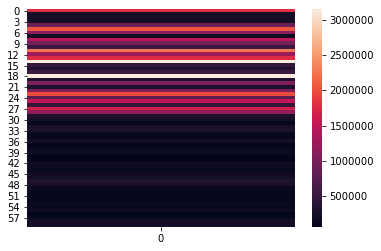

In [20]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(12762629., device='cuda:0')
tensor(737908.3750, device='cuda:0')


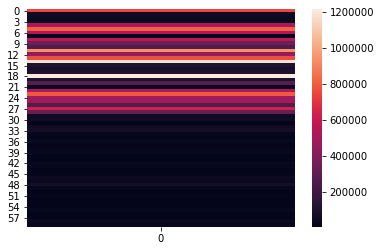

In [21]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(10505.1914, device='cuda:0')
tensor(3894.8081, device='cuda:0')


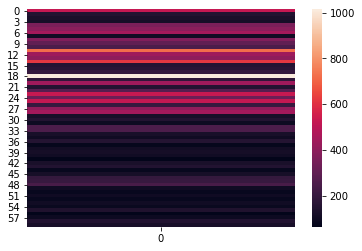

In [22]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(3200.4604, device='cuda:0')
tensor(399.5393, device='cuda:0')


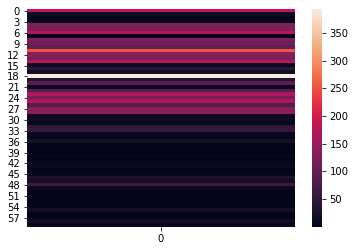

In [23]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [24]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(2800.9211, device='cuda:0')

In [25]:
sub = vae_gumbel_truncated.subset_indices

In [26]:
top_ind = torch.argmax(vae_gumbel_truncated.subset_indices, dim = 1)
top_ind

tensor([ 9, 24, 48, 23, 12,  5, 17, 25,  0,  0, 24, 13, 18, 14,  8, 18, 11, 27,
        27, 14,  6, 11, 26,  4, 18, 25, 20, 23,  4, 33], device='cuda:0')

In [27]:
sum(top_ind < 30)

tensor(28, device='cuda:0')

In [28]:
sum(top_ind >= 30)

tensor(2, device='cuda:0')

LIst logits and subsets. Compare them to each and the ones from other methods (if we had any)

In [29]:
with torch.no_grad():
    z = vae_gumbel_truncated.logit_enc.sum(dim = 0)
z

tensor([  2.2829, -16.6920,  -2.8824,  -4.9541,  -8.7542,   1.6637,  -4.3729,
         -0.9236,  13.0695,   7.2274,  -9.7966,  18.2929,   6.8022, -15.9853,
          9.6377,  -2.2225,  -4.9640,   7.4839,  15.9831,  -6.5730,  10.7879,
         -2.6058, -11.4123,  11.2864, -11.7236,  16.2738, -16.9898,   0.3992,
          7.0559, -12.4353,  -3.4491, -19.6139,  -1.4922,  -4.3976, -11.8324,
         -5.8360,  -3.7638, -16.9310,  -7.6839, -10.4636, -12.2516, -18.4086,
         -7.8239,  -7.9343, -10.7502,  -2.1489,  -1.2306,  -3.2013,  -0.0251,
         -9.8825, -13.7540, -13.3860, -16.8855,  -8.2393, -11.5641,  -6.6695,
        -20.8944,  -5.6887, -10.9590,  -1.3335], device='cuda:0')

In [30]:
torch.sum(vae_gumbel_truncated.subset_indices, dim = 0)

tensor([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 2.5223e-44, 1.0000e+00, 1.0000e+00, 1.5952e-40, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 2.6307e-16, 1.0000e+00,
        3.0000e+00, 3.0758e-29, 9.7052e-01, 0.0000e+00, 1.3313e-11, 2.0000e+00,
        2.0000e+00, 2.0294e+00, 1.0000e+00, 2.0000e+00, 3.0178e-06, 1.0576e-27,
        0.0000e+00, 0.0000e+00, 3.1983e-18, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 9.0113e-24, 4.6109e-05, 0.0000e+00,
        0.0000e+00, 3.6095e-27, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7453e-43,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.6649e-22, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2640e-19],
       device='cuda:0')

Cannot as easily compare as them as you could for the other methods

In [31]:
def top_logits_gumbel_concrete_vae_nsml(data, model):
    assert isinstance(model, ConcreteVAE_NMSL)
    
    with torch.no_grad():
        max_idx = torch.argmax(model.logit_enc, 1, keepdim=True)
        one_hot = Tensor(model.logit_enc.shape)
        one_hot.zero_()
        one_hot.scatter_(1, max_idx, 1)

        all_logits = one_hot.sum(dim = 0)

        w = gumbel_keys(model.logit_enc, EPSILON = torch.finfo(torch.float32).eps)
        w = torch.softmax(w/model.t, dim = -1)
        subset_indices = w.clone().detach()

        #max_idx = torch.argmax(subset_indices, 1, keepdim=True)
        #one_hot = Tensor(subset_indices.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        all_subsets = subset_indices.sum(dim = 0)
        
    return all_logits, all_subsets

In [32]:
top_logits_gumbel_concrete_vae_nsml(test_data, vae_gumbel_truncated)

(tensor([2., 0., 0., 0., 1., 1., 2., 0., 1., 0., 1., 2., 2., 1., 1., 0., 1., 0.,
         5., 0., 0., 0., 1., 1., 1., 2., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.], device='cuda:0'),
 tensor([1.0000e+00, 7.7419e-22, 0.0000e+00, 0.0000e+00, 1.8350e+00, 1.0000e+00,
         3.0000e+00, 0.0000e+00, 1.0000e+00, 3.2919e-04, 1.0000e+00, 2.0000e+00,
         9.9967e-01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 2.7774e-23,
         3.0000e+00, 0.0000e+00, 3.0000e+00, 2.2444e-04, 2.3450e-20, 1.0000e+00,
         2.2972e-01, 2.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
         2.3346e-19, 0.0000e+00, 7.7006e-01, 0.0000e+00, 0.0000e+00, 2.8026e-45,
         9.7250e-43, 0.0000e+00, 2.2004e-26, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.6505e-01, 0.0000e+00, 1.7540e-32, 0.0000e+00, 6.7286e-20, 3.4980e-34,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 